# URL Phishing Detection

24505063 Assignment 2

# Training Phase

## Step 1: Setup Environment

### 1.1 Import Libraries

In [ ]:
# Importing essential libraries for data manipulation, visualization, and model building

# Allows inline plotting within Jupyter notebooks
%matplotlib inline

import pandas as pd # Pandas is used for data handling and manipulation
import seaborn as sns  # Seaborn for data visualization (built on top of matplotlib)
import matplotlib.pyplot as plt  # Matplotlib for generating plots
import numpy as np  # Numpy for numerical operations
import joblib  # Joblib for saving and loading models

# sys and os to work with system paths and environment variables
import sys
import os

from sklearn.model_selection import train_test_split  # Import functions for splitting data into training and test sets
from sklearn.preprocessing import StandardScaler  # StandardScaler is used for feature scaling (normalizing the data)
from sklearn import svm  # SVM (Support Vector Machine) is another model that could be used for classification tasks
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score   # Import various metrics to evaluate model performance (accuracy, classification report, etc.)
from sklearn.linear_model import Perceptron  # Perceptron model from sklearn for binary classification
import tensorflow as tf  # TensorFlow for building neural networks
from tensorflow.keras.models import Sequential  # Keras API from TensorFlow for defining neural network models
from tensorflow.keras.layers import Dense, Input  # Input and Dense layers for constructing the neural network
from tensorflow.keras.callbacks import EarlyStopping  # EarlyStopping callback to stop training when validation loss stops improving
from tensorflow.keras import regularizers  # Regularizers to prevent overfitting in the neural network
from tensorflow.keras.layers import Dropout  # Dropout layer to randomly drop neurons during training to prevent overfitting
from tensorflow.keras.optimizers import Adam  # Adam optimizer for optimizing neural network weights

### 1.2 Set random seeds for reproducability ⏰

To ensure valid testing across multiple sessions

In [ ]:
np.random.seed(22) # Set the random seed for Numpy to ensure reproducibility of results
tf.random.set_seed(22) # Set the random seed for TensorFlow to ensure reproducibility across runs

### 1.3 Mount the Google Drive to access the Dataset:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Step 2: Load Dataset

### 2.1 Change path to the folder contianing the dataset (Change this path as needed):

In [ ]:
%cd /content/gdrive/MyDrive/24505063 Project

/content/gdrive/MyDrive/24505063 Project


### 2.2 Load the dataset:

In [ ]:
data = pd.read_csv('dataset_phishing.csv') # Read the csv file

### 2.3 Check the file was read correctly

In [ ]:
print(data.head()) # Display the first lines of the file

                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                

### 2.4 Check for missing vlaues

In [ ]:
data.info() # Summarise dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

### 2.5 Check for balanced dataset

In [ ]:
data['status'].value_counts() # Count the number of phishing and legit URLs

,count
status,
legitimate,5715
phishing,5715


### 2.6 Convert status attribute to numerical values

In [ ]:
# Change status into int dtype with legitimate as 0 and phishing as 1. This enables input into the models
mapping = {'legitimate':0, 'phishing':1}
data['status'] = data['status'].map(mapping)

### 2.7 Visualise correlation matrix for features

We must drop featuers which poorly correlate with the target variable



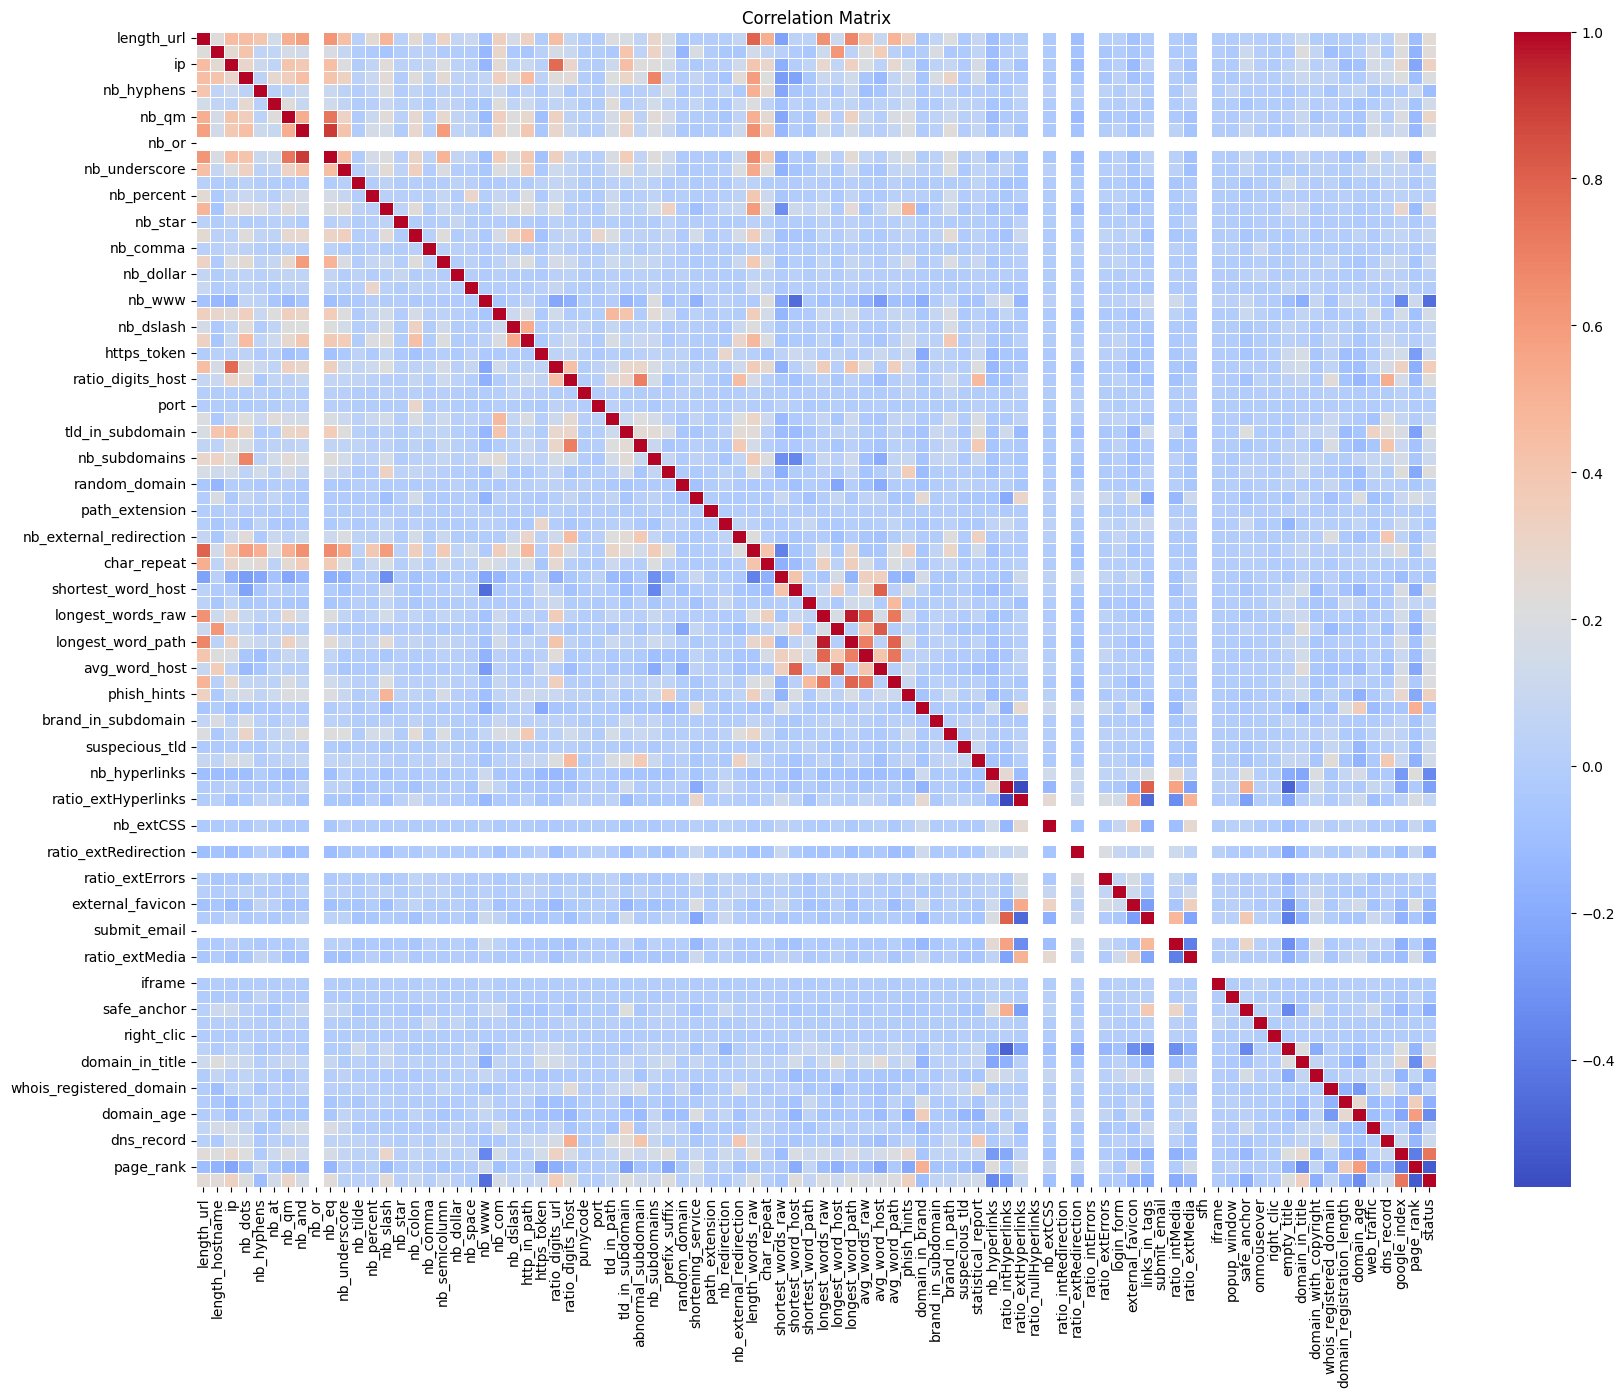

In [ ]:
correlation_matrix = data.corr(numeric_only=True) # Compute the correlation matrix for numerical features in the dataset

plt.figure(figsize=(20, 15)) # Set the figure size for the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5) # Generate a heatmap to visualize the correlations between features
plt.title('Correlation Matrix') # Add a title to the heatmap for clarity
plt.show() # Display the heatmap

### 2.8 Drop features with low predictive power

In [ ]:
# Set a correlation threshold for dropping low-correlated features
# For example, we will set the threshold to 0.1 (i.e., keep only features with correlation > 0.1 or < -0.1 with the target)
correlation_threshold = 0.1
correlation_with_target = correlation_matrix['status'].abs()

# Drop features with correlation below the threshold
low_correlation_features = correlation_with_target[correlation_with_target < correlation_threshold].index
print(f"Dropping the following low-correlation features:\n{list(low_correlation_features)}\n")

data_filtered = data.drop(low_correlation_features, axis=1)# Drop the low-correlation features from the dataset
print(f"New dataset shape: {data_filtered.shape}") # Check the shape of the new dataset
print(data_filtered.info()) # Display the first few rows of the filtered dataset

Dropping the following low-correlation features:
['nb_underscore', 'nb_tilde', 'nb_percent', 'nb_star', 'nb_colon', 'nb_comma', 'nb_dollar', 'nb_space', 'nb_dslash', 'http_in_path', 'punycode', 'port', 'tld_in_path', 'random_domain', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'char_repeat', 'shortest_words_raw', 'shortest_word_path', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extErrors', 'login_form', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'whois_registered_domain', 'web_traffic']

New dataset shape: (11430, 56)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  in

### 2.9 Define features and target

In [ ]:
y = data_filtered['status'] # Define target variable
X = data_filtered.drop(['status', 'url'], axis=1)  # Drop both 'status' and 'url' columns in one step for the features

### 2.10 Split dataset into test, val and  train ⏰

Splitting the dataset like this ensures that models are not evaluated on the same data they were trained on, preventing overfitting and providing a realistic evaluation of model performance.

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42) # First, split off the test set (e.g., 15% for testing)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # Then, split the remaining data into training and validation sets (e.g., 75% for training, 25% for validation)

### 2.11 Scale features

Feature scaling is essential, especially for models like Perceptron and neural networks, which are sensitive to the magnitude of features. Standardizing ensures that no feature dominates the learning process due to its scale. All inputs, including the deployed model must have this scaling.

In [ ]:
# Feature scaling to standardize the data (Perceptron performs better with scaled data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Check for balanced data
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

# Save the scaler
scaler.fit(X_train)  # Fit scaler to training data
joblib.dump(scaler, '/content/gdrive/MyDrive/24505063 Project/scaler.pkl')  # Save the fitted scaler

status
1    3674
0    3612
Name: count, dtype: int64
status
0    1232
1    1197
Name: count, dtype: int64
status
0    871
1    844
Name: count, dtype: int64


['/content/gdrive/MyDrive/24505063 Project/scaler.pkl']

## 3. Train Perceptron Model

### 3.1 Define perceptron

In [ ]:
# Define key hyperparameters for the Perceptron
max_iter = 1000 # Maximum number of iterations over the training data
eta0 = 1 # Learning rate (step size)
tol = 1e-3 # Stopping criterion (stops when loss doesn't improve by this amount)
random_state = 22 # Seed for reproducibility
penalty = None # No regularization (other options: 'l2', 'l1', 'elasticnet')
fit_intercept = True # Whether or not to fit the intercept (bias term)
early_stopping = False # Stop early if validation score doesn’t improve

# Initialize the Perceptron model with explicit hyperparameters
perceptron = Perceptron(
    max_iter=max_iter,
    eta0=eta0,
    tol=tol,
    random_state=random_state,
    penalty=penalty,
    fit_intercept=fit_intercept,
    early_stopping=early_stopping
)

### 3.2 Train the model

In [ ]:
perceptron.fit(X_train, y_train) # Train the model using the training set

Perceptron(eta0=1, random_state=22)

### 3.3 Save the model

In [ ]:
# Define a function to save the model with a custom path
def save_model(model, file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True) # Ensure the directory exists
    joblib.dump(model, file_path) # Save the model to the specified path
    print(f"Model saved to {file_path}")

custom_path = "/content/gdrive/MyDrive/24505063 Project/perceptron_model.pkl" # Set the custom path for saving the model
save_model(perceptron, custom_path) # Save the model using the provided path

Model saved to /content/gdrive/MyDrive/24505063 Project/perceptron_model.pkl


### 3.4 Evaluate on Validation Set

In [ ]:
y_val_pred = perceptron.predict(X_val) # Predict labels
val_accuracy = accuracy_score(y_val, y_val_pred) # Evaluate accuracy to true labels
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%") # Print accuracy

Validation Accuracy: 91.27%


### 3.5 Evaluate on Test Set

Test Accuracy: 91.84%

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       871
           1       0.90      0.94      0.92       844

    accuracy                           0.92      1715
   macro avg       0.92      0.92      0.92      1715
weighted avg       0.92      0.92      0.92      1715



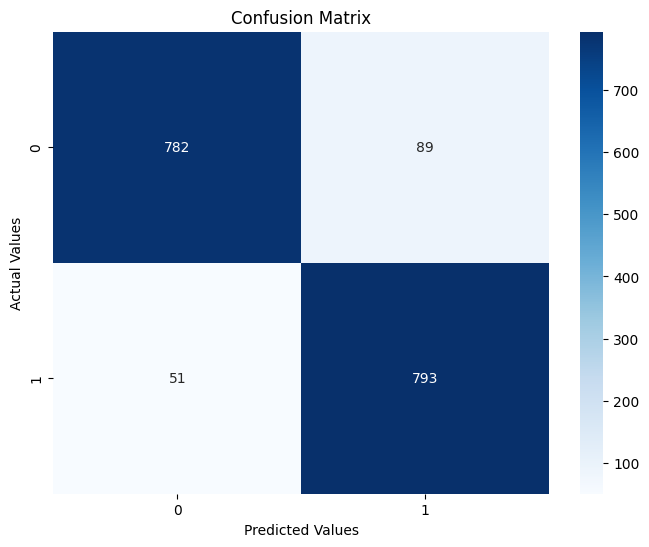

In [ ]:
y_test_pred = perceptron.predict(X_test) # Make predictions on the test set
test_accuracy = accuracy_score(y_test, y_test_pred) # Evaluate the model on the test set
print(f"Test Accuracy: {test_accuracy * 100:.2f}%") # Print accuracy

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred)) # Print classification report for the test set

conf_matrix = confusion_matrix(y_test, y_test_pred) # Generate the confusion matrix using the true and predicted values from the test set

plt.figure(figsize=(8, 6)) # Set the figure size for the confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  # 'fmt="d"' ensures integer display
plt.title('Confusion Matrix') # Add a title to the heatmap for clarity
plt.ylabel('Actual Values') # Label the y-axis as 'Actual Values'
plt.xlabel('Predicted Values') # Label the x-axis as 'Predicted Values'
plt.show() # Display the heatmap

## 4. Train NN

### 4.1 Define the NN Model ⏰

In [ ]:
def create_nn_model(input_dim):
    model = Sequential()  # Initialize a sequential model
    model.add(Input(shape=(input_dim,)))  # Input layer defined by input_dim (number of features)
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # First hidden layer with 32 units, ReLU activation, and L2 regularization
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Second hidden layer with 16 units, ReLU activation, and L2 regularization
    model.add(Dropout(0.3))  # Dropout layer to randomly deactivate 30% of neurons to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 unit for binary classification, sigmoid activation for probabilities

    model.compile(optimizer=Adam(learning_rate=0.00015),  # Compile the model using Adam optimizer
                  loss='binary_crossentropy',  # Binary crossentropy as the loss function
                  metrics=['accuracy'])  # Track accuracy as the performance metric

    return model  # Return the compiled model

### 4.2 Create the model

In [ ]:
input_dim = X_train.shape[1] # Get the number of features for the input layer
print("Number of features:", input_dim) # Print the number of features for validation

nn_model = create_nn_model(input_dim) # Create the neural network model
nn_model.summary() # Print the model architecture

Number of features: 54


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Train the model ⏰

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5) # Early stopping to stop training when validation loss does not improve

# Train the neural network
history = nn_model.fit(
    X_train, y_train,  # Training data (features and labels)
    validation_data=(X_val, y_val),  # Validation data to monitor performance during training
    epochs=70,  # Set the number of epochs to 70 (maximum training iterations)
    batch_size=32,  # Use a batch size of 32 samples for each gradient update
    callbacks=[early_stopping],  # Use early stopping to prevent overfitting if validation loss stops improving
    verbose=1  # Display the training progress (1 for progress bar output)
)

Epoch 1/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5567 - loss: 0.7670 - val_accuracy: 0.7765 - val_loss: 0.5870
Epoch 2/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7620 - loss: 0.5784 - val_accuracy: 0.8827 - val_loss: 0.4759
Epoch 3/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8549 - loss: 0.4779 - val_accuracy: 0.9041 - val_loss: 0.3903
Epoch 4/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8915 - loss: 0.4062 - val_accuracy: 0.9144 - val_loss: 0.3307
Epoch 5/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9059 - loss: 0.3535 - val_accuracy: 0.9201 - val_loss: 0.2908
Epoch 6/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9113 - loss: 0.3167 - val_accuracy: 0.9230 - val_loss: 0.2647
Epoch 7/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9175 - loss: 0.2936 - val_accuracy: 0.9300 - val_loss: 0.2474
Epoch 8/70
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9274 - loss: 0.2718 - val_accuracy: 0.

### 4.4 Save the model

In [ ]:
# Define a function to save the model with a custom path
def save_nn_model(model, file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
    model.save(file_path)  # Save the neural network model to the specified path
    print(f"Neural Network model saved to {file_path}")

custom_path_nn = "/content/gdrive/MyDrive/24505063 Project/nn_model.h5" # Set the custom path for saving the neural network model
save_nn_model(nn_model, custom_path_nn) # Save the neural network model using the custom path

Neural Network model saved to /content/gdrive/MyDrive/24505063 Project/nn_model.h5


### 4.5 Plot Training History ⏰

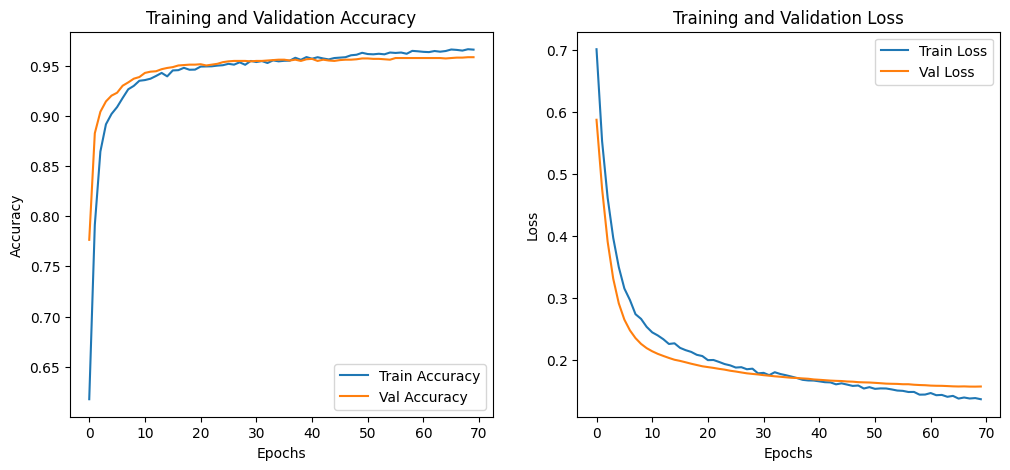

In [ ]:
# Plot training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))  # Set the figure size for the plots

# Plot accuracy
plt.subplot(1, 2, 1)  # Create a subplot for accuracy (1 row, 2 columns, first plot)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Val Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Set the title for the accuracy plot
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to the accuracy plot

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss (1 row, 2 columns, second plot)
plt.plot(history.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Val Loss')  # Plot validation loss
plt.title('Training and Validation Loss')  # Set the title for the loss plot
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to the loss plot

plt.show()  # Display the plots

### 4.6 Display Accuracy Metrics

Test Accuracy: 96.44%
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       871
           1       0.97      0.96      0.96       844

    accuracy                           0.96      1715
   macro avg       0.96      0.96      0.96      1715
weighted avg       0.96      0.96      0.96      1715



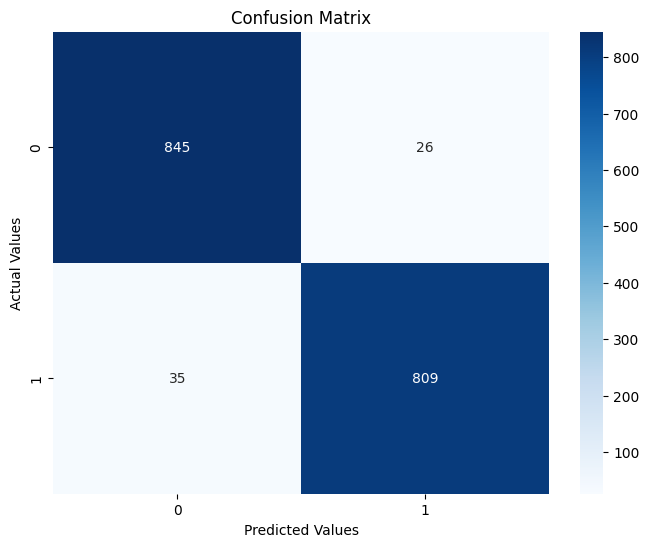

In [ ]:
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test, verbose=0) # Evaluate the model on the test set
print(f"Test Accuracy: {test_accuracy * 100:.2f}%") # Print the accuracy

y_test_pred_prob = nn_model.predict(X_test) # Make predictions on the test set
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Convert probabilities to binary
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred)) # Evaluate performance on the test set

conf_matrix = confusion_matrix(y_test, y_test_pred)  # Generate the confusion matrix using true and predicted labels
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  # Create a heatmap to visualize the confusion matrix with annotations
plt.title('Confusion Matrix')  # Set the title of the plot
plt.ylabel('Actual Values')  # Label the y-axis as 'Actual Values'
plt.xlabel('Predicted Values')  # Label the x-axis as 'Predicted Values'
plt.show()  # Display the heatmap

# Deployment Phase

## 5. Practical Standalone NN Implementation and Testing on a URL ⏰

### 5.1 Mount the Google Drive to access the Dataset:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 5.2 Change path to the folder contianing the models (Change this path as needed):

In [ ]:
%cd /content/gdrive/MyDrive/24505063 Project

/content/gdrive/MyDrive/24505063 Project


### 5.3 Install Dependencies ⏰

In [ ]:
# Install necessary libraries for feature extraction
!pip install python-Levenshtein  # Install the python-Levenshtein library for string similarity calculations
!pip install python-whois  # Install the python-whois library for querying WHOIS domain data
!pip install dnspython  # Install the dnspython library for DNS queries and domain lookups
!pip install tldextract  # Install the tldextract library for parsing top-level domains from URLs
!pip install liac-arff  # Install the liac-arff library for handling ARFF files (used for datasets)

### 5.4 Imports for standalone implementation

In [ ]:
# Standard libraries
import sys  # To manipulate the system path
import os  # To handle directory paths
import pandas as pd  # For creating and handling DataFrames
import numpy as np  # For numerical operations

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler  # For feature scaling

# TensorFlow/Keras imports
from tensorflow.keras.models import load_model  # To load a saved neural network model

### 5.5 Feature Extraction Function

In [ ]:
def extract_url_features(url, status=1):
    """
    Adds the 'scripts' folder to the system path, imports necessary modules,
    and extracts features from a given URL.

    Args:
    - url (str): The URL to extract features from.
    - status (int): Placeholder Value

    Returns:
    - DataFrame: A Pandas DataFrame containing the extracted features after dropping specified columns.
    """

    # Add the 'scripts' folder to the system path
    sys.path.append(os.path.join(os.getcwd(), 'Scripts'))

    # Import necessary modules from the scripts folder
    import content_features as ctnfe
    import url_features as urlfe
    import external_features as extfe
    import feature_extractor as fe

    # Indices of columns to drop
    indices_to_drop = [0, 88, 11, 12, 13, 14, 16, 17, 18, 19, 23, 24, 28, 29, 30, 35,
                       37, 38, 39, 41, 42, 44, 52, 53, 54, 59, 61, 65, 66, 73, 74,
                       76, 77, 81, 84, 88]

    # Extract features from the URL
    features = fe.extract_features(url, status=status)  # Extract features

    # Check if features were extracted successfully
    if features:
        feature_df = pd.DataFrame([features])  # Convert features to a DataFrame

        # Drop the specified columns using their indices
        feature_df = feature_df.drop(feature_df.columns[indices_to_drop], axis=1)
        # Display the DataFrame after dropping the columns
        print("After dropping columns:")
        print(feature_df.info())

        return feature_df  # Return the DataFrame with the extracted features
    else:
        print("Failed to extract features from the URL.")
        return None  # Return None if feature extraction failed

### 5.6 Load the Saved NN model

In [ ]:
def load_nn_model(file_path):
    """
    Load a previously saved neural network model from the specified file path.

    Args:
    - file_path (str): The file path where the model is saved.

    Returns:
    - model: The loaded Keras model.
    """
    try:
        # Load the model from the file path
        model = load_model(file_path)
        print(f"Neural Network model loaded from {file_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

### 5.7 Define function to Categorise NN

In [ ]:
def predict_url_class(features_df, scaler, nn_model):
    """
    Rescales the input features using a pre-fitted scaler, makes predictions using a neural network model,
    and classifies the URL as phishing or legitimate.

    Args:
    - features_df (DataFrame): The DataFrame containing the extracted features for the URL.
    - scaler (object): A fitted StandardScaler object used for feature scaling.
    - nn_model (object): A trained neural network model used to make predictions.

    Returns:
    - str: The classification of the URL as 'Phishing' or 'Legitimate'.
    """

    if features_df is not None:
        # Rescale the input data using the same scaler applied to training data
        features_df_scaled = scaler.transform(features_df)

        # Make predictions using the neural network model
        prediction_prob = nn_model.predict(features_df_scaled)

        # Convert probabilities to binary classification (1 for phishing, 0 for legitimate)
        prediction = (prediction_prob > 0.5).astype(int)

        # Return the classification result
        return 'Phishing' if prediction[0] == 1 else 'Legitimate'
    else:
        return "Feature extraction failed, no prediction made."

### 5.8 Example Usage on Legitimate URL

In [ ]:
# Load the model
custom_path_nn = "/content/gdrive/MyDrive/24505063 Project/nn_model.h5"  # The saved model path
loaded_nn_model = load_nn_model(custom_path_nn)  # Load the neural network model

# Define Scaler
scaler = joblib.load('/content/gdrive/MyDrive/24505063 Project/scaler.pkl')  # Load the saved scaler

# Define the test URL
url = 'https://www.google.com'

# Evaluate URL
features_df = extract_url_features(url, status=0)  # Extract Features
result = predict_url_class(features_df, scaler, loaded_nn_model) # Classify URL
print(f"The URL is classified as: {result}") # Display Classification

Neural Network model loaded from /content/gdrive/MyDrive/24505063 Project/nn_model.h5


After dropping columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1 non-null      int64  
 1   2       1 non-null      int64  
 2   3       1 non-null      int64  
 3   4       1 non-null      int64  
 4   5       1 non-null      int64  
 5   6       1 non-null      int64  
 6   7       1 non-null      int64  
 7   8       1 non-null      int64  
 8   9       1 non-null      int64  
 9   10      1 non-null      int64  
 10  15      1 non-null      int64  
 11  20      1 non-null      int64  
 12  21      1 non-null      int64  
 13  22      1 non-null      int64  
 14  25      1 non-null      int64  
 15  26      1 non-null      float64
 16  27      1 non-null      float64
 17  31      1 non-null      int64  
 18  32      1 non-null      int64  
 19  33      1 non-null      int64  
 20  34      1 non-null      int64  
 21  36      1 non-null 